# Choosing the best classifier for sign language dataset

In [1]:
import os
import pickle

import mediapipe as mp
import cv2
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

import warnings

warnings.filterwarnings('ignore')

In [2]:
data_dict = pickle.load(open('../dataset/dataset_dictionary.pickle', 'rb'))

In [3]:
df = pd.DataFrame(data=data_dict['data'])
df['sign_number'] = data_dict['labels']
df.head()

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,sign_number
0,0.176237,0.265538,0.145103,0.164993,0.091986,0.094154,0.037782,0.047897,0.011824,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.176796,0.266859,0.145541,0.166711,0.092821,0.096287,0.037964,0.049173,0.012594,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.175248,0.268204,0.146128,0.169321,0.094887,0.097236,0.042042,0.049603,0.016205,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.177636,0.270464,0.149813,0.172520,0.096929,0.099372,0.042679,0.051389,0.016549,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.177636,0.270464,0.149813,0.172520,0.096929,0.099372,0.042679,0.051389,0.016549,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# The data we have

- The data we have is coordinates which giving mediapipe based on my own photos of each sign.

- Mediapipe hand landmarks

    There are 21 hand landmarks, each composed of x, y and z coordinates. The x and y coordinates are normalized to [0.0, 1.0] by the image width and height, respectively. The z coordinate represents the landmark depth, with the depth at the wrist being the origin. The smaller the value, the closer the landmark is to the camera. The magnitude of z uses roughly the same scale as x.


- **In the dataset there are such signs as:** *(starting from 0)*

    0. **Like**
    1. **Like front**
    2. **Dislike**
    3. **Dislike front**
    4. **Ok**
    5. **Peace**
    6. **Rock**
    7. **YessPeace**
    8. Shaka
    9. Fuck you
    10. Spock
    11. [Westcoast](https://i.pinimg.com/1200x/5f/de/2b/5fde2bdfbe7d84925c2f71159c22b982.jpg)
    12. [Eastcoast](https://thesource.com/wp-content/uploads/2017/10/Snoop-Dogg-Hints-New-Album-Make-America-Crip-Again.jpg)
    13. [Crips](https://video-images.vice.com/videos/58dc3000466f70ae1467bb8d/lede/1510849962065-gang_initiation_approved_v2-clean.jpeg)

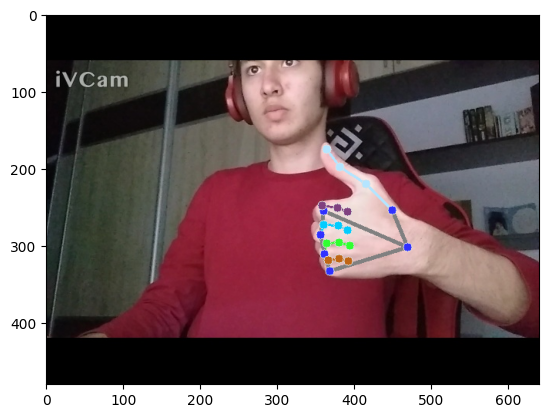

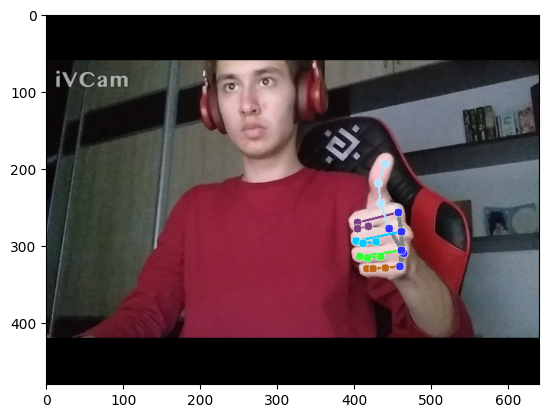

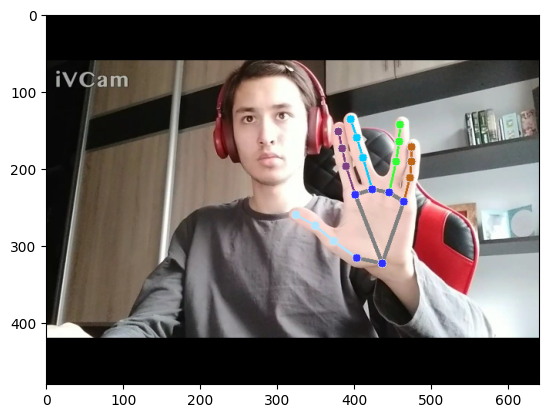

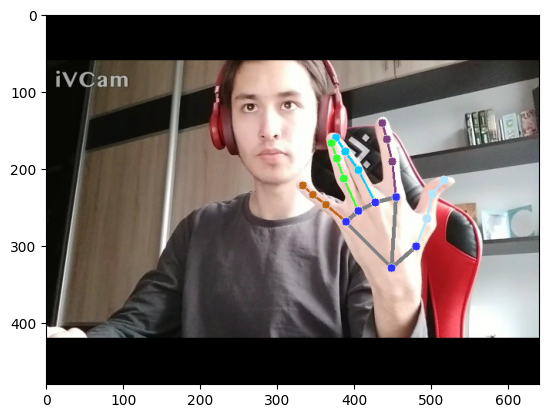

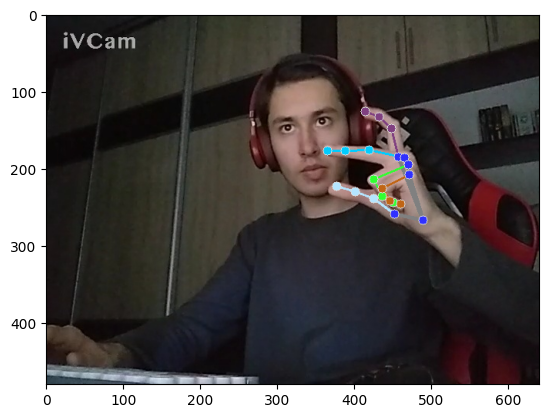

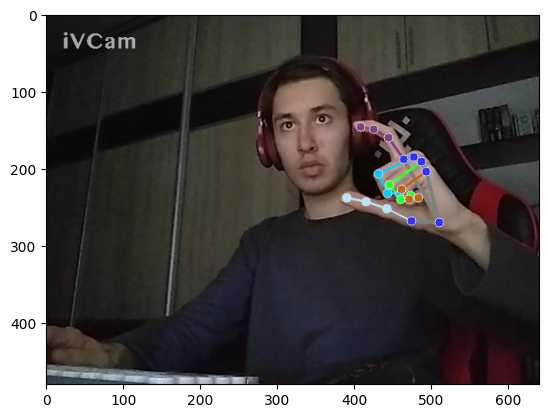

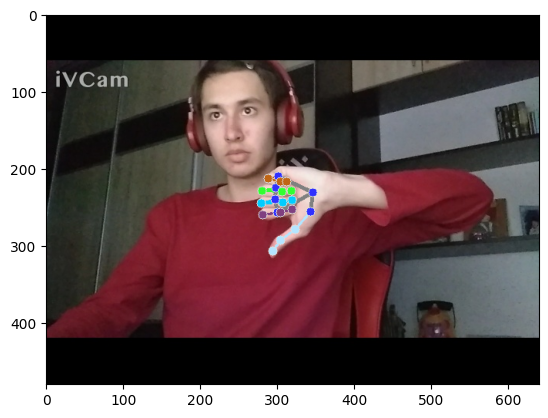

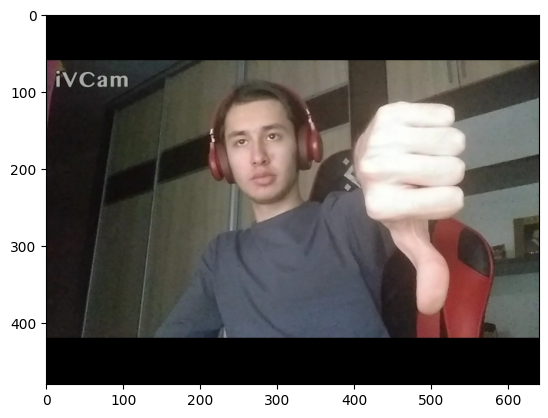

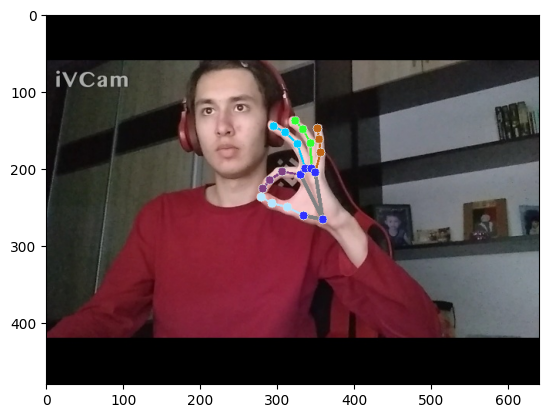

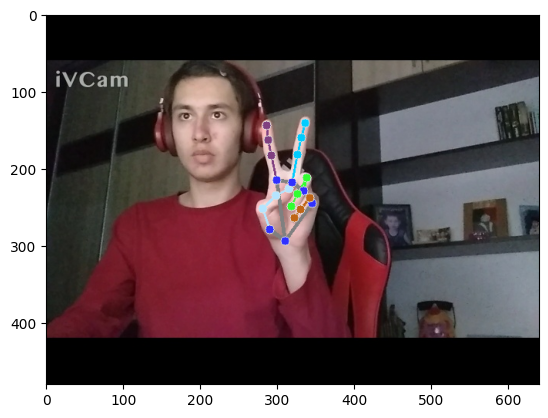

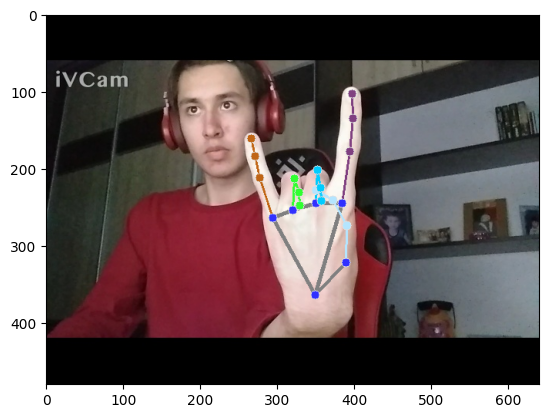

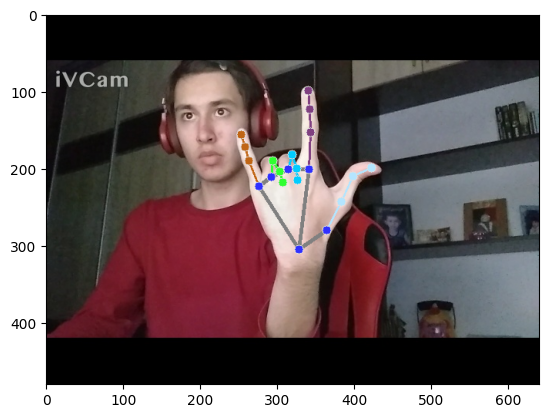

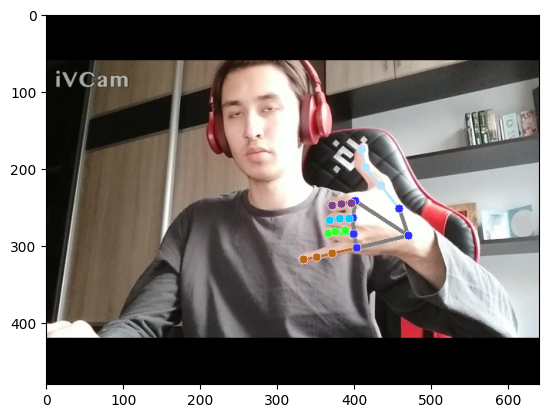

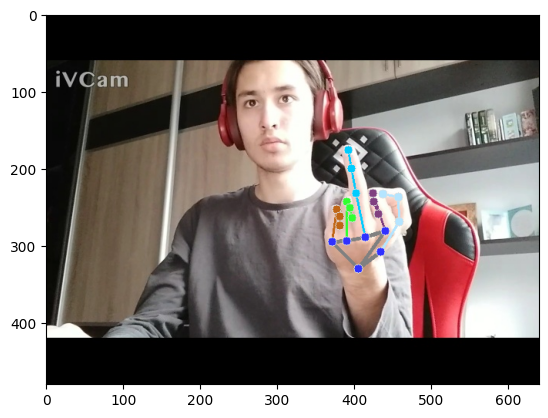

In [4]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

DATA_DIR = './data'

for dir_ in os.listdir(DATA_DIR):
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_))[:1]:
        img = cv2.imread(os.path.join(DATA_DIR, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    img_rgb,  # image to draw
                    hand_landmarks,  # model output
                    mp_hands.HAND_CONNECTIONS,  # hand connections
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style(),
                )

        plt.figure()
        plt.imshow(img_rgb)

plt.show()

# Preparing Data

In [5]:
df = df.drop(df.columns[42:-1], axis='columns')

In [6]:
df[['vertically_mirror_able', 'horizontal_mirror_able', 'vertically_horizontally_mirror_able']] = False
df.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,sign_number,vertically_mirror_able,horizontal_mirror_able,vertically_horizontally_mirror_able
0,0.176237,0.265538,0.145103,0.164993,0.091986,0.094154,0.037782,0.047897,0.011824,0.0,...,0.015047,0.301295,0.037012,0.296828,0.055984,0.301927,0,False,False,False
1,0.176796,0.266859,0.145541,0.166711,0.092821,0.096287,0.037964,0.049173,0.012594,0.0,...,0.013136,0.301031,0.034377,0.296401,0.053103,0.301806,0,False,False,False
2,0.175248,0.268204,0.146128,0.169321,0.094887,0.097236,0.042042,0.049603,0.016205,0.0,...,0.017169,0.306901,0.038989,0.302390,0.057394,0.305908,0,False,False,False
3,0.177636,0.270464,0.149813,0.172520,0.096929,0.099372,0.042679,0.051389,0.016549,0.0,...,0.022632,0.320682,0.045836,0.316598,0.064083,0.317758,0,False,False,False
4,0.177636,0.270464,0.149813,0.172520,0.096929,0.099372,0.042679,0.051389,0.016549,0.0,...,0.022632,0.320682,0.045836,0.316598,0.064083,0.317758,0,False,False,False


In [7]:
mirror_able_signs = [str(sign_number) for sign_number in range(4, 11)]

df.loc[df['sign_number'].isin(mirror_able_signs), ['vertically_mirror_able', 'horizontal_mirror_able',
                                                   'vertically_horizontally_mirror_able']] = True

df

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,sign_number,vertically_mirror_able,horizontal_mirror_able,vertically_horizontally_mirror_able
0,0.176237,0.265538,0.145103,0.164993,0.091986,0.094154,0.037782,0.047897,0.011824,0.000000,...,0.015047,0.301295,0.037012,0.296828,0.055984,0.301927,0,False,False,False
1,0.176796,0.266859,0.145541,0.166711,0.092821,0.096287,0.037964,0.049173,0.012594,0.000000,...,0.013136,0.301031,0.034377,0.296401,0.053103,0.301806,0,False,False,False
2,0.175248,0.268204,0.146128,0.169321,0.094887,0.097236,0.042042,0.049603,0.016205,0.000000,...,0.017169,0.306901,0.038989,0.302390,0.057394,0.305908,0,False,False,False
3,0.177636,0.270464,0.149813,0.172520,0.096929,0.099372,0.042679,0.051389,0.016549,0.000000,...,0.022632,0.320682,0.045836,0.316598,0.064083,0.317758,0,False,False,False
4,0.177636,0.270464,0.149813,0.172520,0.096929,0.099372,0.042679,0.051389,0.016549,0.000000,...,0.022632,0.320682,0.045836,0.316598,0.064083,0.317758,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,0.086077,0.412270,0.151059,0.348153,0.198460,0.249452,0.208767,0.155471,0.189233,0.091406,...,0.015056,0.198139,0.033435,0.219128,0.040676,0.257825,9,True,True,True
1368,0.084629,0.420739,0.151930,0.355534,0.204870,0.258321,0.215883,0.164648,0.196200,0.099687,...,0.016046,0.210179,0.034224,0.233405,0.041615,0.275259,9,True,True,True
1369,0.086568,0.431422,0.155110,0.367461,0.208397,0.270639,0.222211,0.176267,0.206667,0.106133,...,0.021782,0.214721,0.039066,0.237881,0.044554,0.279312,9,True,True,True
1370,0.086568,0.431422,0.155110,0.367461,0.208397,0.270639,0.222211,0.176267,0.206667,0.106133,...,0.021782,0.214721,0.039066,0.237881,0.044554,0.279312,9,True,True,True


In [8]:
df.loc[df['sign_number'] == '11', ['horizontal_mirror_able']] = True

df

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,sign_number,vertically_mirror_able,horizontal_mirror_able,vertically_horizontally_mirror_able
0,0.176237,0.265538,0.145103,0.164993,0.091986,0.094154,0.037782,0.047897,0.011824,0.000000,...,0.015047,0.301295,0.037012,0.296828,0.055984,0.301927,0,False,False,False
1,0.176796,0.266859,0.145541,0.166711,0.092821,0.096287,0.037964,0.049173,0.012594,0.000000,...,0.013136,0.301031,0.034377,0.296401,0.053103,0.301806,0,False,False,False
2,0.175248,0.268204,0.146128,0.169321,0.094887,0.097236,0.042042,0.049603,0.016205,0.000000,...,0.017169,0.306901,0.038989,0.302390,0.057394,0.305908,0,False,False,False
3,0.177636,0.270464,0.149813,0.172520,0.096929,0.099372,0.042679,0.051389,0.016549,0.000000,...,0.022632,0.320682,0.045836,0.316598,0.064083,0.317758,0,False,False,False
4,0.177636,0.270464,0.149813,0.172520,0.096929,0.099372,0.042679,0.051389,0.016549,0.000000,...,0.022632,0.320682,0.045836,0.316598,0.064083,0.317758,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,0.086077,0.412270,0.151059,0.348153,0.198460,0.249452,0.208767,0.155471,0.189233,0.091406,...,0.015056,0.198139,0.033435,0.219128,0.040676,0.257825,9,True,True,True
1368,0.084629,0.420739,0.151930,0.355534,0.204870,0.258321,0.215883,0.164648,0.196200,0.099687,...,0.016046,0.210179,0.034224,0.233405,0.041615,0.275259,9,True,True,True
1369,0.086568,0.431422,0.155110,0.367461,0.208397,0.270639,0.222211,0.176267,0.206667,0.106133,...,0.021782,0.214721,0.039066,0.237881,0.044554,0.279312,9,True,True,True
1370,0.086568,0.431422,0.155110,0.367461,0.208397,0.270639,0.222211,0.176267,0.206667,0.106133,...,0.021782,0.214721,0.039066,0.237881,0.044554,0.279312,9,True,True,True


# Adding variety to the signs

We need to create the following types of signs variations: *inverse, vertically mirrored, horizontal mirrored, vertically&horizontally mirrored*.

But we don't need creating any pictures, we have just use our coordinates.

Let's say our sign is by number 0, then the *vertically mirrored* is by label *0_0*, the *horizontal mirrored* is by label *0_1* and the *vertically&horizontally mirrored* is by label *0_2*

And we don't do this with some signs, which can't be turned over

In [9]:
new_df = df

for i, df_line in df.iterrows():
    sign_number = df_line['sign_number']

    df_line_x = df_line[:42:2]
    df_line_y = df_line[1:42:2]

    x_min, y_min = df_line_x.min(), df_line_y.min()
    x_max, y_max = df_line_x.max(), df_line_y.max()

    vertically_mirrored = []
    horizontal_mirrored = []
    vertically_horizontally_mirrored = []

    mirrors = (vertically_mirrored, horizontal_mirrored, vertically_horizontally_mirrored)
    mirror_able_columns = ['vertically_mirror_able', 'horizontal_mirror_able', 'vertically_horizontally_mirror_able']

    for x, y in zip(df_line_x, df_line_y):
        vertically_mirrored.extend((x, y_max - y))
        horizontal_mirrored.extend((x_max - x, y))
        vertically_horizontally_mirrored.extend((x_max - x, y_max - y))

    for mirror, column, j in zip(mirrors, mirror_able_columns, ['_0', '_1', '_2']):
        if df_line[column] is True:
            mirror.extend((sign_number + j, *df_line[mirror_able_columns]))
            new_df = pd.concat([new_df, pd.DataFrame([mirror], columns=df.columns)], ignore_index=True)

new_df

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,sign_number,vertically_mirror_able,horizontal_mirror_able,vertically_horizontally_mirror_able
0,0.176237,0.265538,0.145103,0.164993,0.091986,0.094154,0.037782,0.047897,0.011824,0.000000,...,0.015047,0.301295,0.037012,0.296828,0.055984,0.301927,0,False,False,False
1,0.176796,0.266859,0.145541,0.166711,0.092821,0.096287,0.037964,0.049173,0.012594,0.000000,...,0.013136,0.301031,0.034377,0.296401,0.053103,0.301806,0,False,False,False
2,0.175248,0.268204,0.146128,0.169321,0.094887,0.097236,0.042042,0.049603,0.016205,0.000000,...,0.017169,0.306901,0.038989,0.302390,0.057394,0.305908,0,False,False,False
3,0.177636,0.270464,0.149813,0.172520,0.096929,0.099372,0.042679,0.051389,0.016549,0.000000,...,0.022632,0.320682,0.045836,0.316598,0.064083,0.317758,0,False,False,False
4,0.177636,0.270464,0.149813,0.172520,0.096929,0.099372,0.042679,0.051389,0.016549,0.000000,...,0.022632,0.320682,0.045836,0.316598,0.064083,0.317758,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3558,0.135643,0.431422,0.067101,0.367461,0.013814,0.270639,0.000000,0.176267,0.015544,0.106133,...,0.200429,0.214721,0.183144,0.237881,0.177657,0.279312,9_1,True,True,True
3559,0.135643,0.000000,0.067101,0.063961,0.013814,0.160783,0.000000,0.255155,0.015544,0.325289,...,0.200429,0.216701,0.183144,0.193541,0.177657,0.152110,9_2,True,True,True
3560,0.083614,0.000000,0.154998,0.060420,0.211685,0.156405,0.226269,0.250781,0.210608,0.319692,...,0.020408,0.211215,0.038728,0.186952,0.046315,0.144218,9_0,True,True,True
3561,0.142655,0.428397,0.071271,0.367977,0.014584,0.271992,0.000000,0.177616,0.015661,0.108705,...,0.205861,0.217182,0.187541,0.241445,0.179954,0.284179,9_1,True,True,True


# Creating and training the model

In [10]:
inputs = new_df.drop(['sign_number', 'vertically_mirror_able', 'horizontal_mirror_able', 'vertically_horizontally_mirror_able'], axis=1)
target = new_df['sign_number']

In [11]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': (100, 150, 200)
        }
    },
    'Bagging': {
        'model': BaggingClassifier(max_samples=0.8, oob_score=True),
        'params': {
            'base_estimator': (DecisionTreeClassifier(), SVC(), LogisticRegression()),
            'n_estimators': (100, 150, 200)
        }
    },
}

In [12]:
scores = []

for model_name, mp in model_params.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, n_iter=20)

    clf.fit(inputs, target)  # training data

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,random_forest,0.992702,{'n_estimators': 150}
1,Bagging,0.992698,"{'n_estimators': 100, 'base_estimator': SVC()}"


# Training and saving the best model

The best model as you can see above is RandomForestClassifier with 150 number of trees or Bagging with DecisionTreeClassifier, which is the same thing

In [13]:
model = BaggingClassifier(max_samples=0.8, oob_score=True, n_estimators=150, base_estimator=DecisionTreeClassifier())
model.fit(inputs, target)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.8,
                  n_estimators=150, oob_score=True)

In [14]:
with open('model.pickle', 'wb') as file:
    pickle.dump(model, file)